## Level 3: Unit sales of all products, aggregated for all stores

In [1]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import WRMSSEEvaluator

SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



***

In [2]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["store_id","ds"])
        .agg({"q":"sum",
              "state_id":lambda x: int(x.unique()),
              "snap":lambda x: int(x.unique()),
              "event_name_1":lambda x: int(x.unique()),
              "lw_type":lambda x: int(x.unique()),
              "lw_day":lambda x: int(x.unique()),
              "prev_lw":lambda x: int(x.unique()),
              "post_lw":lambda x: int(x.unique()), 
              "prev_christmas":lambda x: int(x.unique()),
              "post_christmas":lambda x: int(x.unique()),
              "prev_thanksgiving":lambda x: int(x.unique()),
             })
        .reset_index()
       )

data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)
data.sort_values(["store_id","ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

In [3]:
weights_level3 = pd.read_parquet("../input/weights_level3.parquet")
weights_level3.head()

,store_id,weight
0,1,0.110888
1,2,0.110247
2,3,0.155628
3,4,0.065608
4,5,0.077561


In [4]:
scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales = compute_scaling(scaling_input, agg_columns=["store_id"]).rename({"q":"s"}, axis=1)
scales.head()

,store_id,s
0,1,865.992302
1,2,758.015494
2,3,961.931475
3,4,316.500720
4,5,596.928132


In [5]:
# outlier removal
remove_idx = data.query("ds.dt.month == 12 & ds.dt.day == 25").index
data.drop(remove_idx, axis=0, inplace=True)

In [6]:
#weights = (weights_level3
#    .merge(scales, how="inner", on=["store_id"])
#    .assign(weight = lambda x: x.weight/x.s)
#    .assign(weight = lambda x: x.weight/x.weight.median())
#    .drop(["s"], axis=1)
#)
#weights.head()

In [7]:
#data = pd.merge(data, weights, how="left", on=["store_id"])
#data.head()

***
### time series visualization

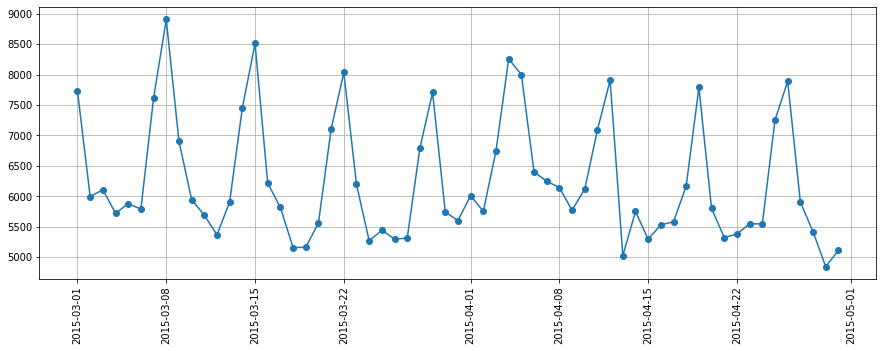

In [8]:
store_id = 3
start_date = '2015-03-01'
end_date = '2015-04-30'

df = data.query("store_id == @store_id & @start_date <= ds <= @end_date")

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-")
plt.xticks(rotation=90)
plt.grid()
plt.show()

***

In [9]:
valid_periods = [(pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
                 (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19")),
                 (pd.to_datetime("2016-02-27"), pd.to_datetime("2016-03-26")),
                 (pd.to_datetime("2016-03-27"), pd.to_datetime("2016-04-24")),
                ]
valid_periods

[(Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')),
 (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')),
 (Timestamp('2016-02-27 00:00:00'), Timestamp('2016-03-26 00:00:00')),
 (Timestamp('2016-03-27 00:00:00'), Timestamp('2016-04-24 00:00:00'))]

***
### training validation models

In [10]:
model_params = {
    'objective': 'l2', 
    'metric': 'None', 
    'num_iterations': 100000, 
    'early_stopping_rounds': 300, 
    'bagging_freq': 1, 
    'num_threads': 10, 
    'learning_rate': 0.29527215922256966, 
    'num_leaves': 31, 'max_bin': 163, 
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.6000000000000001, 
    'min_data_in_leaf': 24, 
    'min_gain_to_split': 1, 
    'lambda_l2': 0.504534786307544, 
    'seed': 71}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    #"month_cos",
    #"month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "categorical_features":{
        "store_id":"default",
        "state_id":"default",
        "event_name_1":"default",
        "snap":"default"},
    "ts_uid_columns":["store_id"],  
}

In [11]:
# 4+ years of history
train_history = 1800

In [11]:
models = list()
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    model_kwargs["trend_models"] = compute_trend_models(_train_data,
                                                        _valid_index,
                                                        ts_uid_columns=["store_id"])

    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    evaluator = WRMSSEEvaluator(_fcaster.valid_features.loc[:, ["ds"]+_fcaster.ts_uid_columns+["y"]], 
                                weights_level3, 
                                scales,
                                ts_uid_columns=_fcaster.ts_uid_columns)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})

    
    models.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)

############################################### 1/4 ################################################
##### Validation period: (Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 4022.16it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's wrmsse: 0.541659
[50]	valid_0's wrmsse: 0.438901
[75]	valid_0's wrmsse: 0.421622
[100]	valid_0's wrmsse: 0.413799
[125]	valid_0's wrmsse: 0.401899
[150]	valid_0's wrmsse: 0.389818
[175]	valid_0's wrmsse: 0.38654
[200]	valid_0's wrmsse: 0.383165
[225]	valid_0's wrmsse: 0.382737
[250]	valid_0's wrmsse: 0.379191
[275]	valid_0's wrmsse: 0.378429
[300]	valid_0's wrmsse: 0.377365
[325]	valid_0's wrmsse: 0.376632
[350]	valid_0's wrmsse: 0.373421
[375]	valid_0's wrmsse: 0.371909
[400]	valid_0's wrmsse: 0.369543
[425]	valid_0's wrmsse: 0.369562
[450]	valid_0's wrmsse: 0.367622
[475]	valid_0's wrmsse: 0.366297
[500]	valid_0's wrmsse: 0.36561
[525]	valid_0's wrmsse: 0.365048
[550]	valid_0's wrmsse: 0.364463
[575]	valid_0's wrmsse: 0.364177
[600]	valid_0's wrmsse: 0.363855
[625]	valid_0's wrmsse: 0.363183
[650]	valid_0's wrmsse: 0.361995
[675]	valid_0's wrmsse: 0.360887
[700]	valid_0's wrmsse: 0.360337
[725]	valid_0's wrm

100%|██████████| 10/10 [00:00<00:00, 14841.84it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's wrmsse: 0.744209
[50]	valid_0's wrmsse: 0.663924
[75]	valid_0's wrmsse: 0.637192
[100]	valid_0's wrmsse: 0.621341
[125]	valid_0's wrmsse: 0.610965
[150]	valid_0's wrmsse: 0.606493
[175]	valid_0's wrmsse: 0.602005
[200]	valid_0's wrmsse: 0.600143
[225]	valid_0's wrmsse: 0.596394
[250]	valid_0's wrmsse: 0.59598
[275]	valid_0's wrmsse: 0.594331
[300]	valid_0's wrmsse: 0.592978
[325]	valid_0's wrmsse: 0.590599
[350]	valid_0's wrmsse: 0.588267
[375]	valid_0's wrmsse: 0.587436
[400]	valid_0's wrmsse: 0.58695
[425]	valid_0's wrmsse: 0.585969
[450]	valid_0's wrmsse: 0.584213
[475]	valid_0's wrmsse: 0.583123
[500]	valid_0's wrmsse: 0.582314
[525]	valid_0's wrmsse: 0.582415
[550]	valid_0's wrmsse: 0.581508
[575]	valid_0's wrmsse: 0.581069
[600]	valid_0's wrmsse: 0.580716
[625]	valid_0's wrmsse: 0.578794
[650]	valid_0's wrmsse: 0.579335
[675]	valid_0's wrmsse: 0.579958
[700]	valid_0's wrmsse: 0.579007
[725]	valid_0's wrm

100%|██████████| 10/10 [00:00<00:00, 8348.54it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's wrmsse: 0.797819
[50]	valid_0's wrmsse: 0.695586
[75]	valid_0's wrmsse: 0.657005
[100]	valid_0's wrmsse: 0.619998
[125]	valid_0's wrmsse: 0.602072
[150]	valid_0's wrmsse: 0.593519
[175]	valid_0's wrmsse: 0.583576
[200]	valid_0's wrmsse: 0.573785
[225]	valid_0's wrmsse: 0.566936
[250]	valid_0's wrmsse: 0.564699
[275]	valid_0's wrmsse: 0.56289
[300]	valid_0's wrmsse: 0.559162
[325]	valid_0's wrmsse: 0.557789
[350]	valid_0's wrmsse: 0.556101
[375]	valid_0's wrmsse: 0.554596
[400]	valid_0's wrmsse: 0.553856
[425]	valid_0's wrmsse: 0.553742
[450]	valid_0's wrmsse: 0.553812
[475]	valid_0's wrmsse: 0.552108
[500]	valid_0's wrmsse: 0.550975
[525]	valid_0's wrmsse: 0.55104
[550]	valid_0's wrmsse: 0.550846
[575]	valid_0's wrmsse: 0.549628
[600]	valid_0's wrmsse: 0.550361
[625]	valid_0's wrmsse: 0.548794
[650]	valid_0's wrmsse: 0.548511
[675]	valid_0's wrmsse: 0.546307
[700]	valid_0's wrmsse: 0.545616
[725]	valid_0's wrm

100%|██████████| 10/10 [00:00<00:00, 11043.45it/s]


Training until validation scores don't improve for 250 rounds
[25]	valid_0's wrmsse: 0.707634
[50]	valid_0's wrmsse: 0.576313
[75]	valid_0's wrmsse: 0.528051
[100]	valid_0's wrmsse: 0.495531
[125]	valid_0's wrmsse: 0.485578
[150]	valid_0's wrmsse: 0.489027
[175]	valid_0's wrmsse: 0.49118
[200]	valid_0's wrmsse: 0.491948
[225]	valid_0's wrmsse: 0.491822
[250]	valid_0's wrmsse: 0.493901
[275]	valid_0's wrmsse: 0.497007
[300]	valid_0's wrmsse: 0.499397
[325]	valid_0's wrmsse: 0.498112
[350]	valid_0's wrmsse: 0.501979
[375]	valid_0's wrmsse: 0.503262
Early stopping, best iteration is:
[135]	valid_0's wrmsse: 0.482966


***
### training final model

In [12]:
#model_kwargs["model_params"]["num_iterations"] = int(np.median(best_iterations))
model_kwargs["model_params"]["num_iterations"] = 166
model_kwargs["model_params"]

{'objective': 'l2',
 'metric': 'None',
 'num_iterations': 166,
 'early_stopping_rounds': 300,
 'bagging_freq': 1,
 'num_threads': 10,
 'learning_rate': 0.29527215922256966,
 'num_leaves': 31,
 'max_bin': 163,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.6000000000000001,
 'min_data_in_leaf': 24,
 'min_gain_to_split': 1,
 'lambda_l2': 0.504534786307544,
 'seed': 71}

In [13]:
train_data = data.copy(deep=True)
all_models = list()

for seed in SEEDS:
    model_kwargs["model_params"]["seed"] = seed
    model_kwargs["trend_models"] = compute_trend_models(train_data, ts_uid_columns=["store_id"])
    fcaster = LightGBMForecaster(**model_kwargs)
    fcaster.prepare_features(train_data=train_data);
    fcaster.fit()
    all_models.append(fcaster)

100%|██████████| 10/10 [00:00<00:00, 10313.02it/s]


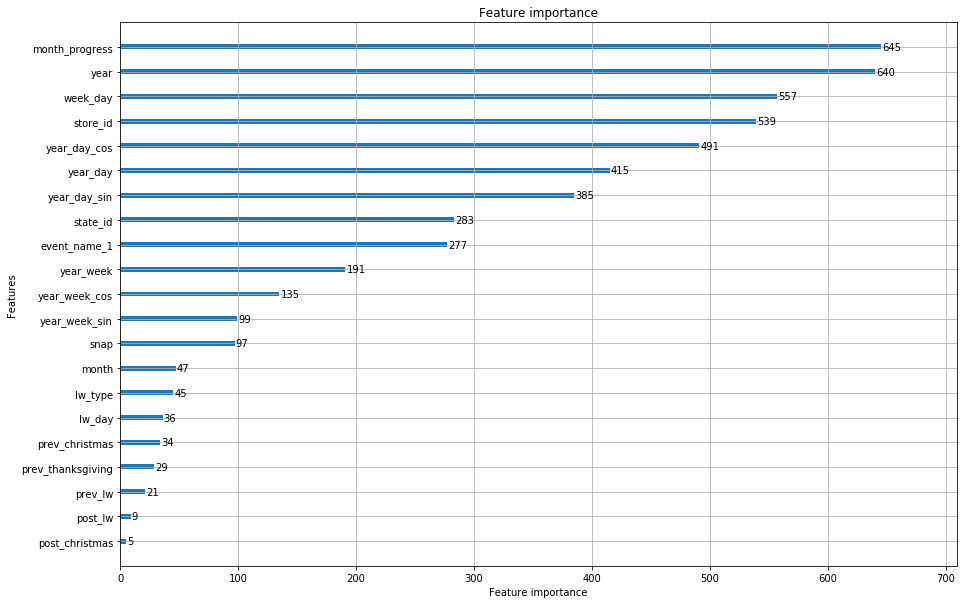

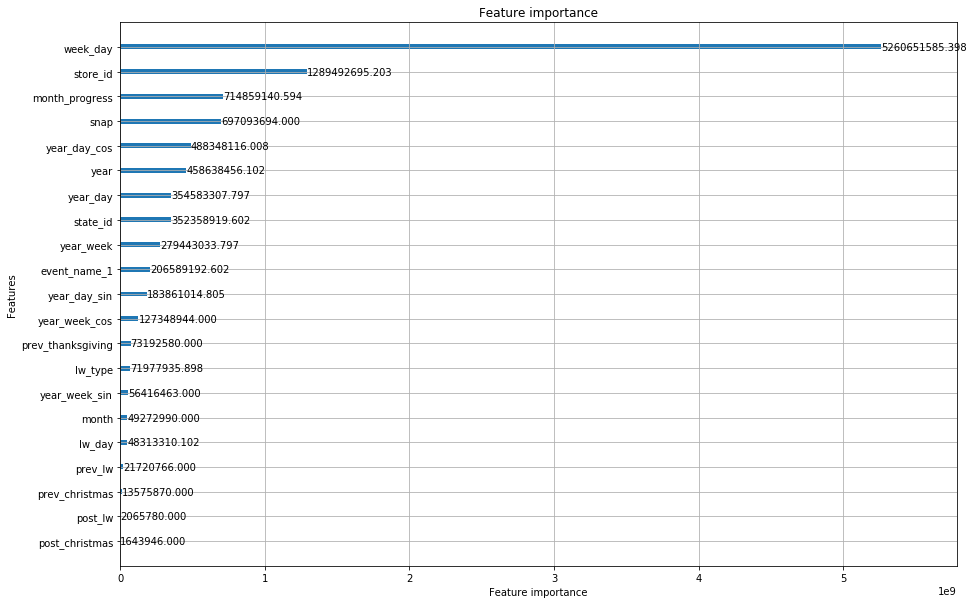

In [14]:
fcaster = all_models[7]
lgb.plot_importance(fcaster.model.model, importance_type="split", figsize=(15,10));
lgb.plot_importance(fcaster.model.model, importance_type="gain", figsize=(15,10));

***
### estimating residuals

In [59]:
%%time
left_date = train_data.ds.max() - pd.DateOffset(years=3)

all_predictions = list()
for fcaster in all_models:
    predictions = fcaster.predict(train_data.query("ds >= @left_date").loc[:, data.columns.drop("y")])
    all_predictions.append(predictions)
predictions = all_predictions[0].copy(deep=True)
predictions["y_pred"] = np.mean([_predictions.y_pred for _predictions in all_predictions], axis=0)

CPU times: user 34.3 s, sys: 6.66 s, total: 40.9 s
Wall time: 4.4 s


In [60]:
residuals_raw = (pd.merge(train_data, predictions, how="inner", on=["store_id","ds"])
                 .assign(residual = lambda x: x.y - x.y_pred)
                 .loc[:, ["ds","store_id","y","y_pred","residual"]])

In [61]:
#%%time
#n_repetitions = 20
#sample_size = 0.66
#all_residual_deviance = list()
#for i in range(n_repetitions):
#    _residual_deviance = (residuals_raw.groupby(["store_id"]).apply(lambda x: x.sample(frac=sample_size))
#                          .reset_index(drop=True)
#                          .groupby(["store_id"])["residual"].std()
#                          .reset_index())
#    all_residual_deviance.append(_residual_deviance)

In [62]:
#residual_deviance = all_residual_deviance[0].copy(deep=True)
#residual_deviance["residual"] = np.mean([_residual_deviance.residual.values for _residual_deviance in all_residual_deviance], axis=0)
#residual_deviance

In [63]:
%%time
def compute_residual_deviance(df):
    q01 = df.residual.quantile(0.01)
    q99 = df.residual.quantile(0.99)
    df["residual"] = df.query("@q01 <= residual <= @q99").residual.std()
    return df.loc[:, ["store_id","residual"]].drop_duplicates(subset=["store_id"])

residual_deviance = (residuals_raw
                     .groupby(["store_id"]).apply(compute_residual_deviance)
                     .reset_index(drop=True))
residual_deviance

CPU times: user 82 ms, sys: 2.27 ms, total: 84.2 ms
Wall time: 81.9 ms


,store_id,residual
0,1,176.396988
1,2,175.782588
2,3,224.945131
3,4,115.035598
4,5,139.825362
5,6,178.203500
6,7,162.354227
7,8,169.358728
8,9,198.176699
9,10,157.453584


In [64]:
residual_deviance.to_parquet("../output/residuals_level3-v4.parquet", index=False)

***
### prediction

In [18]:
valid_dataframe = (pd.read_parquet("../input/valid_dataframe.parquet")
                   .loc[:, train_data.columns.drop("y")]
                   .drop_duplicates()
                   #.merge(weights, how="left", on="state_id")
                  )
eval_dataframe = (pd.read_parquet("../input/eval_dataframe.parquet")
                  .loc[:, train_data.columns.drop("y")]
                  .drop_duplicates()
                  #.merge(weights, how="left", on="state_id")
                 )

In [19]:
all_forecasts = list()
for fcaster in all_models:
    _forecast = fcaster.predict(pd.concat([valid_dataframe, eval_dataframe], ignore_index=True))
    all_forecasts.append(_forecast)
    
forecast = all_forecasts[0].copy(deep=True)
forecast["y_pred"] = np.mean([_forecast.y_pred for _forecast in all_forecasts], axis=0)

In [20]:
forecast.to_csv("../output/forecast_level3-v2.csv", index=False)

***